In [1]:
#이건 feature 를 뽑아내고 검증하는 작업까지만 실습해보는 정도
#groupby 를 통해 원하는 item 모두에 적용하는 방법을 생각해봐야돼
import pandas as pd
import numpy as np

#시각화 할 라이브러리
import matplotlib.pyplot as plt

#모델 라이브러리 선언 
#datasets 는 랜덤하게 데이터를 7:3으로 뽑아냄 => 판매량을 예측할 때는 현재 특정시점과 대응되는 과거의 특정시점에 기준두고 나눠야 해 ex. 2019.7월  알고싶으면 2018.7 기준으로 나눠
#tree 는 Decision tree 만드는 라이브러리, 교수님이 패키지 배포도 해보래...py 로 
from sklearn import datasets, tree, linear_model

In [2]:
#모델 정확도 라이브러리 선언
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import r2_score
# from sklearn.metrics import mean_absolute_percentage_error 얘는 없나봐

In [3]:
featuresData =pd.read_csv("../dataset/feature_regression_example.csv")
#컬럼설명_REGIONID: 지역정보, PRODUCTGROUP: 상품군정보, PRODUCT: 연주차 정보, ITEM: 판매량 Sellout, YEARWEEK: 연주차, QTY: 판매량, HOLIDAY: 홀리데이 여부, HCLUS: 홀리데이(대규모, 소규모여부), PROMOTION: 프로모션 여부, PRO_PERCENT: 할인율 

In [4]:
featuresData.head()

,REGIONID,PRODUCTGROUP,PRODUCT,ITEM,YEARWEEK,YEAR,WEEK,QTY,HOLIDAY,HCLUS,PROMOTION,PRO_PERCENT
0,SEOUL_BANK_001,PG02,PRODUCT0010,ITEM0115,201501,2015,1,1225,Y,1,Y,0.209442
1,SEOUL_BANK_001,PG02,PRODUCT0010,ITEM0115,201502,2015,2,968,N,4,Y,0.209442
2,SEOUL_BANK_001,PG02,PRODUCT0010,ITEM0115,201503,2015,3,1209,N,4,Y,0.208155
3,SEOUL_BANK_001,PG02,PRODUCT0010,ITEM0115,201504,2015,4,1810,Y,2,Y,0.208155
4,SEOUL_BANK_001,PG02,PRODUCT0010,ITEM0115,201505,2015,5,1773,N,4,Y,0.208155


### 1.타입 통합/ 특성 숫자컬럼 추가 

In [5]:
featuresData[["YEARWEEK","YEAR","WEEK","QTY","HCLUS"]] = featuresData[["YEARWEEK","YEAR","WEEK","QTY","HCLUS"]].astype(int)
featuresData[["REGIONID", "PRODUCTGROUP", "PRODUCT","ITEM"]]  = featuresData[["REGIONID", "PRODUCTGROUP", "PRODUCT","ITEM"]].astype(str)
featuresData["PRO_PERCENT"] = featuresData["PRO_PERCENT"].astype(float)
featuresData.dtypes

REGIONID         object
PRODUCTGROUP     object
PRODUCT          object
ITEM             object
YEARWEEK          int32
YEAR              int32
WEEK              int32
QTY               int32
HOLIDAY          object
HCLUS             int32
PROMOTION        object
PRO_PERCENT     float64
dtype: object

In [6]:
#홀리데이/ 프로모션 여부에 따라 숫자 배정 후 컬럼추가
featuresData["HO_YN"] = np.where( featuresData["HOLIDAY"] == "Y", 1, featuresData["HOLIDAY"] == 0)
featuresData["PRO_YN"] = np.where( featuresData["PROMOTION"] == "Y", 1, featuresData["PROMOTION"] == 0)
featuresData.dtypes

REGIONID         object
PRODUCTGROUP     object
PRODUCT          object
ITEM             object
YEARWEEK          int32
YEAR              int32
WEEK              int32
QTY               int32
HOLIDAY          object
HCLUS             int32
PROMOTION        object
PRO_PERCENT     float64
HO_YN             int32
PRO_YN            int32
dtype: object

In [7]:
featuresData.head()

,REGIONID,PRODUCTGROUP,PRODUCT,ITEM,YEARWEEK,YEAR,WEEK,QTY,HOLIDAY,HCLUS,PROMOTION,PRO_PERCENT,HO_YN,PRO_YN
0,SEOUL_BANK_001,PG02,PRODUCT0010,ITEM0115,201501,2015,1,1225,Y,1,Y,0.209442,1,1
1,SEOUL_BANK_001,PG02,PRODUCT0010,ITEM0115,201502,2015,2,968,N,4,Y,0.209442,0,1
2,SEOUL_BANK_001,PG02,PRODUCT0010,ITEM0115,201503,2015,3,1209,N,4,Y,0.208155,0,1
3,SEOUL_BANK_001,PG02,PRODUCT0010,ITEM0115,201504,2015,4,1810,Y,2,Y,0.208155,1,1
4,SEOUL_BANK_001,PG02,PRODUCT0010,ITEM0115,201505,2015,5,1773,N,4,Y,0.208155,0,1


In [8]:

featuresData = featuresData[(featuresData.YEARWEEK >= 201501) & (featuresData.YEARWEEK  <= 201652)]

### 2. 특성선정 / 데이터 분리 

In [9]:
#상관관계 구하는 함수: 데이터프레임명.corr()
corrDf  =  featuresData.corr()

#인덱스컬럼 초기화
corrResult = corrDf.reset_index()

#상관관계 계수 비율 선정
featuresStd = 0.5

#Feature 선택 _ 내가 선정한 과거정보의 기준을 제시하는 거야  abs 는 절대값
#                           _ 내가 선정한 과거정보의 기준을 제시하는 거야 / 조건에 해당하는 애들의 컬럼명을 리스트로 만들어서 변수에 담아
features = corrResult[(corrResult.QTY != 1) & (abs(corrResult.QTY) > featuresStd)]["index"].tolist()
#내가 구할 값인 QTY 는 label 로 선언
label = ['QTY']

In [10]:
#위에 디버깅================================================================================================
corrDf

,YEARWEEK,YEAR,WEEK,QTY,HCLUS,PRO_PERCENT,HO_YN,PRO_YN
YEARWEEK,1.000000,0.956598,0.275593,0.112267,-0.071586,0.404889,0.049867,0.205916
YEAR,0.956598,1.000000,-0.016493,0.028931,0.028593,0.321193,-0.031106,0.195931
WEEK,0.275593,-0.016493,1.000000,0.289766,-0.339943,0.329705,0.273710,0.060206
QTY,0.112267,0.028931,0.289766,1.000000,-0.537230,0.700195,0.505932,0.612451
HCLUS,-0.071586,0.028593,-0.339943,-0.537230,1.000000,-0.545619,-0.974601,-0.374072
PRO_PERCENT,0.404889,0.321193,0.329705,0.700195,-0.545619,1.000000,0.487062,0.898554
HO_YN,0.049867,-0.031106,0.273710,0.505932,-0.974601,0.487062,1.000000,0.365148
PRO_YN,0.205916,0.195931,0.060206,0.612451,-0.374072,0.898554,0.365148,1.000000


In [11]:
#인덱스컬럼 초기화
corrResult = corrDf.reset_index()
corrResult

,index,YEARWEEK,YEAR,WEEK,QTY,HCLUS,PRO_PERCENT,HO_YN,PRO_YN
0,YEARWEEK,1.000000,0.956598,0.275593,0.112267,-0.071586,0.404889,0.049867,0.205916
1,YEAR,0.956598,1.000000,-0.016493,0.028931,0.028593,0.321193,-0.031106,0.195931
2,WEEK,0.275593,-0.016493,1.000000,0.289766,-0.339943,0.329705,0.273710,0.060206
3,QTY,0.112267,0.028931,0.289766,1.000000,-0.537230,0.700195,0.505932,0.612451
4,HCLUS,-0.071586,0.028593,-0.339943,-0.537230,1.000000,-0.545619,-0.974601,-0.374072
5,PRO_PERCENT,0.404889,0.321193,0.329705,0.700195,-0.545619,1.000000,0.487062,0.898554
6,HO_YN,0.049867,-0.031106,0.273710,0.505932,-0.974601,0.487062,1.000000,0.365148
7,PRO_YN,0.205916,0.195931,0.060206,0.612451,-0.374072,0.898554,0.365148,1.000000


In [12]:
#상관관계 계수 비율 선정
featuresStd = 0.5
#Feature 선택 
features = corrResult[(corrResult.QTY != 1) & (abs(corrResult.QTY) > featuresStd)]["index"].tolist()

In [13]:
abs(corrResult.QTY)

0    0.112267
1    0.028931
2    0.289766
3    1.000000
4    0.537230
5    0.700195
6    0.505932
7    0.612451
Name: QTY, dtype: float64

In [14]:
features

['HCLUS', 'PRO_PERCENT', 'HO_YN', 'PRO_YN']

In [15]:
#내가 구할 값인 QTY 는 label 로 선언
label = ['QTY']
label

['QTY']

In [16]:
#여기까지 디버깅=============================================================================================

In [17]:
#데이터 분리 
#학습에 쓰이는 데이터는 trainingData 두 개_ 특성과 답을 주고 같이 학습시키는 것임
yearweekStd = 201630
trainingData_features = featuresData[featuresData.YEARWEEK <= yearweekStd][features] #좌측의 조건에 해당하는 데이터 중 features컬럼에 해당하는 데이터만 변수에 넣어주세요
trainingData_label = featuresData[featuresData.YEARWEEK <= yearweekStd][label]
testData_features = featuresData[featuresData.YEARWEEK > yearweekStd][features]
testData_label = featuresData[featuresData.YEARWEEK > yearweekStd ] #답지까지 같이 있는 전체 셋
testData_label_linear = featuresData[featuresData.YEARWEEK > yearweekStd ]

### 3. 모델 적용_tree Decision

In [18]:
#모델 선언 _ 원하는 모델 함수는 나중에 구글링해서 찾으면 돼 
model_method = tree.DecisionTreeRegressor()

#학습 Learning(Feature & Label) _ 학습시킬 때 쓰는 함수 fit . 특성과 답을 같이 주고 학습시킴
model = model_method.fit(trainingData_features, trainingData_label)

In [19]:
model

DecisionTreeRegressor(criterion='mse', max_depth=None, max_features=None,
           max_leaf_nodes=None, min_impurity_decrease=0.0,
           min_impurity_split=None, min_samples_leaf=1,
           min_samples_split=2, min_weight_fraction_leaf=0.0,
           presort=False, random_state=None, splitter='best')

### 3.1 모델 적용_linear

In [20]:
#모델 선언_linear 로
model_method_linearRegression = linear_model.LinearRegression()

#학습
model_linear = model_method_linearRegression.fit(trainingData_features, trainingData_label)

### 4.1예측_tree Decision

In [21]:
predict = model.predict(testData_features) #위에서 나온 model 에 검증할 testData 를 넣어봄

In [22]:
#얘의 크기는 testData의 features 크기만큼 떨어짐 - 데이터를 담고 있는 집합 자료형
#얘를 정답지랑 join 시키는 것이 중요함 => join 을 자유롭게 할 수 있어야 해
#회사에서 일할 때, 전체 코드 중 머신러닝 사용은 일부분이니깐, 데이터 정제 등 다른 작업도  자유로워야 해
predict

array([1606.5       , 1606.5       ,  350.71428571, 1434.6       ,
       1434.6       , 1434.6       , 1434.6       , 1434.6       ,
       1606.5       , 1606.5       , 2620.42857143, 1606.5       ,
        350.71428571, 2193.8       , 2193.8       , 2193.8       ,
       2193.8       , 2193.8       , 1434.6       , 1434.6       ,
       1434.6       , 1434.6       ])

### 4.2 예측_linear

In [23]:
predict_linear = model_linear.predict(testData_features)
predict_linear

array([[1411.29171929],
       [1411.29171929],
       [ 300.43091536],
       [2004.96200456],
       [2004.96200456],
       [2004.96200456],
       [1586.12154967],
       [1586.12154967],
       [1411.29171929],
       [1411.29171929],
       [1799.54021119],
       [1411.29171929],
       [ 300.43091536],
       [2734.87329525],
       [2734.87329525],
       [2734.87329525],
       [2734.87329525],
       [2734.87329525],
       [2285.44087736],
       [1856.31310796],
       [1856.31310796],
       [2275.15356285]])

### 5.1 데이터 정리_tree Decision

In [24]:
#데이터프레임으로 변환
predictData = pd.DataFrame(predict)

In [25]:
#컬럼명 주입
featuresData["PREDICT"] = predictData

In [26]:
featuresData.head()

,REGIONID,PRODUCTGROUP,PRODUCT,ITEM,YEARWEEK,YEAR,WEEK,QTY,HOLIDAY,HCLUS,PROMOTION,PRO_PERCENT,HO_YN,PRO_YN,PREDICT
0,SEOUL_BANK_001,PG02,PRODUCT0010,ITEM0115,201501,2015,1,1225,Y,1,Y,0.209442,1,1,1606.500000
1,SEOUL_BANK_001,PG02,PRODUCT0010,ITEM0115,201502,2015,2,968,N,4,Y,0.209442,0,1,1606.500000
2,SEOUL_BANK_001,PG02,PRODUCT0010,ITEM0115,201503,2015,3,1209,N,4,Y,0.208155,0,1,350.714286
3,SEOUL_BANK_001,PG02,PRODUCT0010,ITEM0115,201504,2015,4,1810,Y,2,Y,0.208155,1,1,1434.600000
4,SEOUL_BANK_001,PG02,PRODUCT0010,ITEM0115,201505,2015,5,1773,N,4,Y,0.208155,0,1,1434.600000


In [27]:
#테스트데이터와 예측값을 붙이세요1
testData_label["PREDICT"] = predict
predict

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


array([1606.5       , 1606.5       ,  350.71428571, 1434.6       ,
       1434.6       , 1434.6       , 1434.6       , 1434.6       ,
       1606.5       , 1606.5       , 2620.42857143, 1606.5       ,
        350.71428571, 2193.8       , 2193.8       , 2193.8       ,
       2193.8       , 2193.8       , 1434.6       , 1434.6       ,
       1434.6       , 1434.6       ])

In [28]:
testData_label.head()

,REGIONID,PRODUCTGROUP,PRODUCT,ITEM,YEARWEEK,YEAR,WEEK,QTY,HOLIDAY,HCLUS,PROMOTION,PRO_PERCENT,HO_YN,PRO_YN,PREDICT
83,SEOUL_BANK_001,PG02,PRODUCT0010,ITEM0115,201631,2016,31,1522,N,4,Y,0.280258,0,1,1606.500000
84,SEOUL_BANK_001,PG02,PRODUCT0010,ITEM0115,201632,2016,32,2100,N,4,Y,0.280258,0,1,1606.500000
85,SEOUL_BANK_001,PG02,PRODUCT0010,ITEM0115,201633,2016,33,43,N,4,N,0.000000,0,0,350.714286
86,SEOUL_BANK_001,PG02,PRODUCT0010,ITEM0115,201634,2016,34,1700,Y,1,Y,0.308584,1,1,1434.600000
87,SEOUL_BANK_001,PG02,PRODUCT0010,ITEM0115,201635,2016,35,1514,Y,1,Y,0.308584,1,1,1434.600000


In [29]:
#테스트데이터와 예측값을 붙이세요2
#concat 으로 합치기 
concatData = pd.concat([testData_label.reset_index(drop=True), predictData], axis=1)
concatData = concatData.drop ([0], axis=1) #위에서 얘가 생겨버려서 drop 시킴

In [30]:
len(concatData.YEARWEEK)

22

In [31]:
concatData.head()

,REGIONID,PRODUCTGROUP,PRODUCT,ITEM,YEARWEEK,YEAR,WEEK,QTY,HOLIDAY,HCLUS,PROMOTION,PRO_PERCENT,HO_YN,PRO_YN,PREDICT
0,SEOUL_BANK_001,PG02,PRODUCT0010,ITEM0115,201631,2016,31,1522,N,4,Y,0.280258,0,1,1606.500000
1,SEOUL_BANK_001,PG02,PRODUCT0010,ITEM0115,201632,2016,32,2100,N,4,Y,0.280258,0,1,1606.500000
2,SEOUL_BANK_001,PG02,PRODUCT0010,ITEM0115,201633,2016,33,43,N,4,N,0.000000,0,0,350.714286
3,SEOUL_BANK_001,PG02,PRODUCT0010,ITEM0115,201634,2016,34,1700,Y,1,Y,0.308584,1,1,1434.600000
4,SEOUL_BANK_001,PG02,PRODUCT0010,ITEM0115,201635,2016,35,1514,Y,1,Y,0.308584,1,1,1434.600000


In [32]:
concatData.to_csv("./concatData_resgressor.csv")

### 5.2 데이터정리_ linear  

In [33]:
predictData_linear = pd.DataFrame(predict_linear)
featuresData_linear = pd.concat([testData_label_linear.reset_index(drop=True), predictData_linear.reset_index(drop=True)], axis =1) 

In [34]:
len(featuresData_linear.YEARWEEK)

22

In [35]:
featuresData_linear.head()

,REGIONID,PRODUCTGROUP,PRODUCT,ITEM,YEARWEEK,YEAR,WEEK,QTY,HOLIDAY,HCLUS,PROMOTION,PRO_PERCENT,HO_YN,PRO_YN,0
0,SEOUL_BANK_001,PG02,PRODUCT0010,ITEM0115,201631,2016,31,1522,N,4,Y,0.280258,0,1,1411.291719
1,SEOUL_BANK_001,PG02,PRODUCT0010,ITEM0115,201632,2016,32,2100,N,4,Y,0.280258,0,1,1411.291719
2,SEOUL_BANK_001,PG02,PRODUCT0010,ITEM0115,201633,2016,33,43,N,4,N,0.000000,0,0,300.430915
3,SEOUL_BANK_001,PG02,PRODUCT0010,ITEM0115,201634,2016,34,1700,Y,1,Y,0.308584,1,1,2004.962005
4,SEOUL_BANK_001,PG02,PRODUCT0010,ITEM0115,201635,2016,35,1514,Y,1,Y,0.308584,1,1,2004.962005


In [36]:
featuresData_linear.head()
featuresData_linear["PREDICT"] = featuresData_linear[0]
#featuresData_linear = featuresData_linear.drop([0],axis=1) #컬럼 떨어뜨리고 변수에 담아줘야해!!!

In [37]:
featuresData_linear.head()

,REGIONID,PRODUCTGROUP,PRODUCT,ITEM,YEARWEEK,YEAR,WEEK,QTY,HOLIDAY,HCLUS,PROMOTION,PRO_PERCENT,HO_YN,PRO_YN,0,PREDICT
0,SEOUL_BANK_001,PG02,PRODUCT0010,ITEM0115,201631,2016,31,1522,N,4,Y,0.280258,0,1,1411.291719,1411.291719
1,SEOUL_BANK_001,PG02,PRODUCT0010,ITEM0115,201632,2016,32,2100,N,4,Y,0.280258,0,1,1411.291719,1411.291719
2,SEOUL_BANK_001,PG02,PRODUCT0010,ITEM0115,201633,2016,33,43,N,4,N,0.000000,0,0,300.430915,300.430915
3,SEOUL_BANK_001,PG02,PRODUCT0010,ITEM0115,201634,2016,34,1700,Y,1,Y,0.308584,1,1,2004.962005,2004.962005
4,SEOUL_BANK_001,PG02,PRODUCT0010,ITEM0115,201635,2016,35,1514,Y,1,Y,0.308584,1,1,2004.962005,2004.962005


### 6.1 정확도 측정_tree Decision

In [38]:
#MAE 실측값과 예측값의 차이 절대값
mean_absolute_error(concatData["QTY"], concatData["PREDICT"])

402.7435064935065

In [39]:
#RMSE(MSE) root mean square 오차 제곱을 시킨 것// 이후, 루트를 씌워서 안정화한 값을 MAE 와 비교
#_ 오차가 고르게 나면 MAE 와 RMSE를 안정화한 값이 유사하지만, 특정값만 오차가 크면 두 값이 다름 
#MAE 와 RMSE를 안정화한 값이 유사한 것이 모델이 안정적인 정도를 말해줌
#MAPE(mean absolute percentage error)도 있음 
mean_squared_error(concatData["QTY"], concatData["PREDICT"])

import math #math.sqrt : 루트한 값과 비교를 해줘야 함 
math.sqrt(mean_squared_error(concatData["QTY"], concatData["PREDICT"]))

476.11553668877247

In [40]:
#R2
r2_score(concatData["QTY"], concatData["PREDICT"])

0.5144917252719985

### 6.2 정확도 측정_linear

In [41]:
mean_absolute_error(featuresData_linear["QTY"], featuresData_linear["PREDICT"])

566.617239476098

In [42]:
math.sqrt(mean_squared_error(featuresData_linear["QTY"], featuresData_linear["PREDICT"]))

722.6052639386677

In [43]:
r2_score(featuresData_linear["QTY"], featuresData_linear["PREDICT"])

-0.11834080332946595

### 7.1 시각화_tree Decision

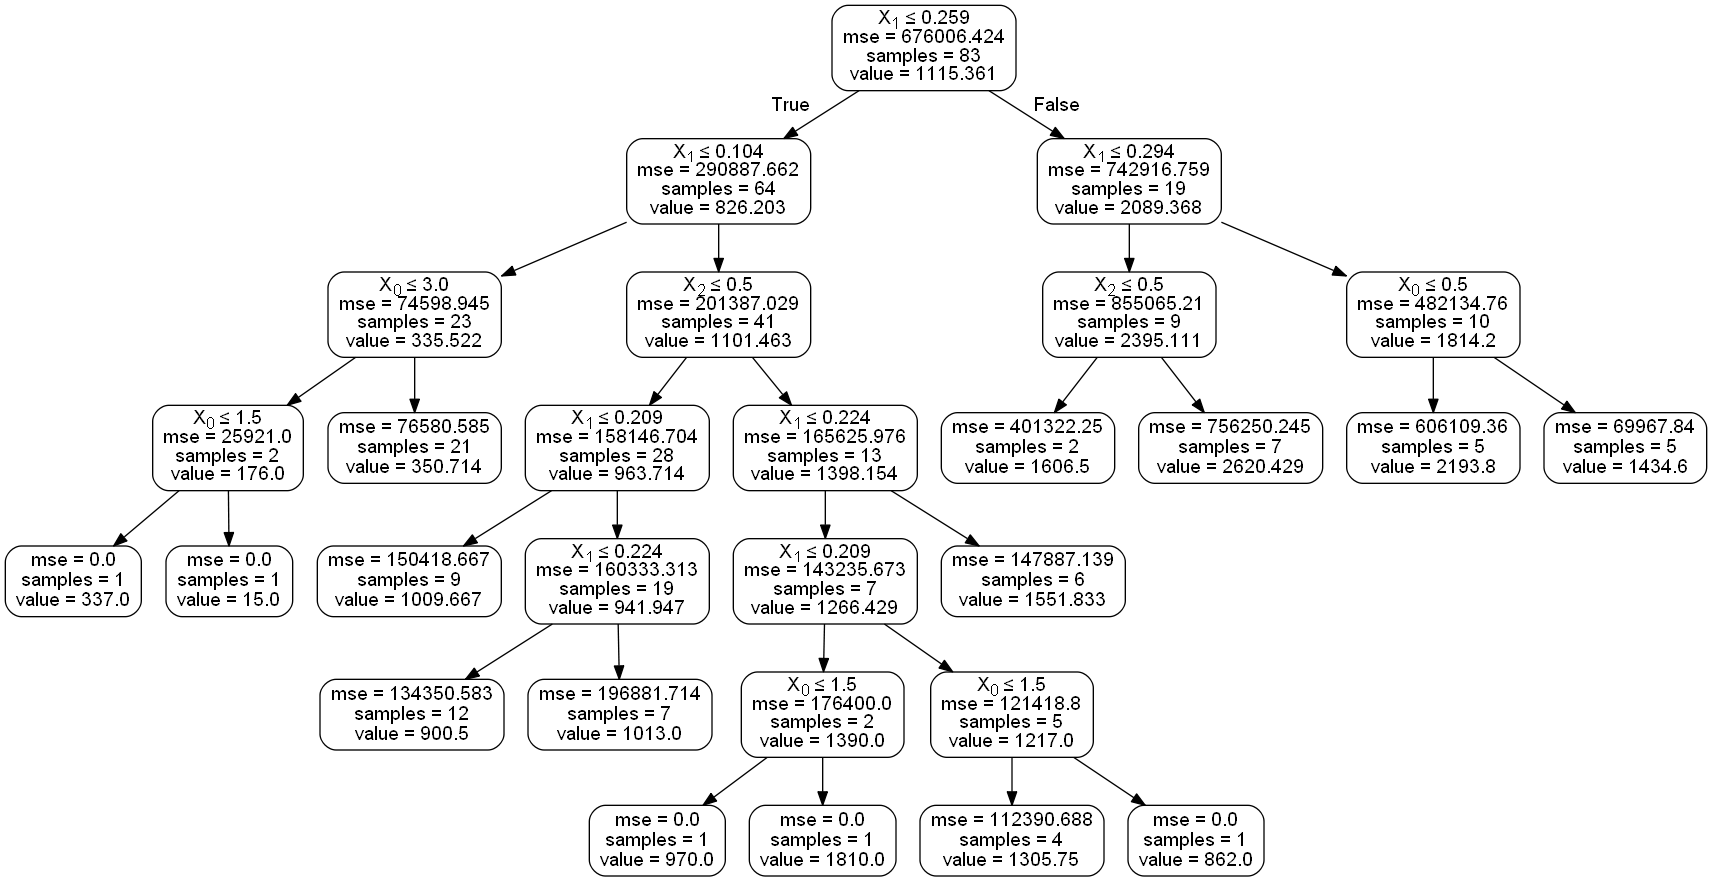

In [44]:
from sklearn.externals.six import StringIO  
from IPython.display import Image  
from sklearn.tree import export_graphviz
import pydotplus
dot_data = StringIO()
export_graphviz(model, out_file=dot_data, 
                rounded=True,
                special_characters=True)
graph = pydotplus.graph_from_dot_data(dot_data.getvalue())  
Image(graph.create_png())

### 7.2 시각화_linear

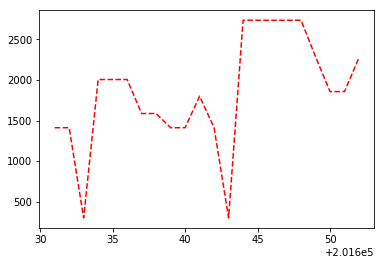

In [45]:
x = featuresData_linear.YEARWEEK
y = featuresData_linear.PREDICT

plt.plot(x,y,"r--", label = "tree")

### 7.3 시각화 tree_linear_QTY

In [46]:
(concatData.QTY, concatData.PREDICT, featuresData_linear.PREDICT)

(0     1522
 1     2100
 2       43
 3     1700
 4     1514
 5     1501
 6     1491
 7      806
 8     2111
 9     2400
 10    2010
 11    1900
 12     141
 13    1615
 14    1574
 15    1800
 16    2600
 17    2412
 18    1955
 19    1800
 20    1173
 21     332
 Name: QTY, dtype: int32, 0     1606.500000
 1     1606.500000
 2      350.714286
 3     1434.600000
 4     1434.600000
 5     1434.600000
 6     1434.600000
 7     1434.600000
 8     1606.500000
 9     1606.500000
 10    2620.428571
 11    1606.500000
 12     350.714286
 13    2193.800000
 14    2193.800000
 15    2193.800000
 16    2193.800000
 17    2193.800000
 18    1434.600000
 19    1434.600000
 20    1434.600000
 21    1434.600000
 Name: PREDICT, dtype: float64, 0     1411.291719
 1     1411.291719
 2      300.430915
 3     2004.962005
 4     2004.962005
 5     2004.962005
 6     1586.121550
 7     1586.121550
 8     1411.291719
 9     1411.291719
 10    1799.540211
 11    1411.291719
 12     300.430915
 13    2734.873

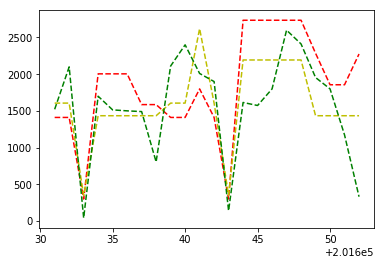

In [47]:
#이중축 쓸 거 아니면 이렇게만 쓰면 돼
x = featuresData_linear.YEARWEEK
y1 = featuresData_linear.PREDICT
y2 = concatData.PREDICT
y3 = featuresData_linear.QTY

plt.plot(x,y1,'r--', lw = 1.5, label="Linear")
plt.plot(x,y2,'y--', lw = 1.5, label="Tree")
plt.plot(x,y3,'g--', lw = 1.5, label="QTY")